In [24]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
import os

In [3]:
class NPYImageDataset(Dataset):
    def __init__(self, image_array, label_array, transform=None):
        self.images = image_array
        self.labels = label_array
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx].astype(np.uint8)  # Convert back to uint8
        img = Image.fromarray(img, mode='L')     # Grayscale image
        if self.transform:
            img = self.transform(img)
        label = self.labels[idx]
        return img, label

In [4]:
data_dir = "data" # output path

train_images = np.load(os.path.join(data_dir, "train_images.npy"))
train_labels = np.load(os.path.join(data_dir, "train_labels.npy"))
val_images = np.load(os.path.join(data_dir, "val_images.npy"))
val_labels = np.load(os.path.join(data_dir, "val_labels.npy"))
test_images = np.load(os.path.join(data_dir, "test_images.npy"))
test_labels = np.load(os.path.join(data_dir, "test_labels.npy"))

In [5]:
from torchvision import transforms

alexnet_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  # 3 channels for AlexNet
    transforms.ToTensor()
])

In [6]:
batch_size = 1  # for saving features one-by-one

train_dataset = NPYImageDataset(train_images, train_labels, transform=alexnet_transform)
val_dataset = NPYImageDataset(val_images, val_labels, transform=alexnet_transform)
test_dataset = NPYImageDataset(test_images, test_labels, transform=alexnet_transform)

from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [8]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from math import floor
import matplotlib.pyplot as plt

In [9]:
# Adjust these paths to your environment
master_path = "/"
data_path = os.path.join(master_path, "data")
feature_path = os.path.join(master_path, "data")

# 9-class QuickDraw task
classes = ["apple", "bee", "cat", "eyeglasses", "fish", "flower", "house", "pencil", "pizza"]


In [10]:
batch_size = 1  # for saving features one-by-one

train_dataset = NPYImageDataset(train_images, train_labels, transform=alexnet_transform)
val_dataset = NPYImageDataset(val_images, val_labels, transform=alexnet_transform)
test_dataset = NPYImageDataset(test_images, test_labels, transform=alexnet_transform)

from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [12]:
alexnet = torchvision.models.alexnet(pretrained=True).to('cuda' if torch.cuda.is_available() else 'cpu')
alexnet.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def save_alexnet_features(data_loader, dataset_type="train"):
    print(f"Processing {dataset_type} data...")
    n = 0
    for img, label in data_loader:
        img = img.to(device)
        features = alexnet.features(img)
        features_tensor = features.cpu().detach()

        class_name = classes[label.item()]
        save_dir = os.path.join(feature_path, dataset_type, class_name)
        os.makedirs(save_dir, exist_ok=True)

        torch.save(features_tensor.squeeze(0), os.path.join(save_dir, f"{n}.tensor"))

        if n % 100 == 0:
            print(f"Saved {n} features...")
        n += 1

save_alexnet_features(train_loader, "train")
save_alexnet_features(val_loader, "val")
save_alexnet_features(test_loader, "test")


Processing train data...
Saved 0 features...
Saved 100 features...
Saved 200 features...
Saved 300 features...
Saved 400 features...
Saved 500 features...
Saved 600 features...
Saved 700 features...
Saved 800 features...
Saved 900 features...
Saved 1000 features...
Saved 1100 features...
Saved 1200 features...
Saved 1300 features...
Saved 1400 features...
Saved 1500 features...
Saved 1600 features...
Saved 1700 features...
Saved 1800 features...
Saved 1900 features...
Saved 2000 features...
Saved 2100 features...
Saved 2200 features...
Saved 2300 features...
Saved 2400 features...
Saved 2500 features...
Saved 2600 features...
Saved 2700 features...
Saved 2800 features...
Saved 2900 features...
Saved 3000 features...
Saved 3100 features...
Saved 3200 features...
Saved 3300 features...
Saved 3400 features...
Saved 3500 features...
Saved 3600 features...
Saved 3700 features...
Saved 3800 features...
Saved 3900 features...
Saved 4000 features...
Saved 4100 features...
Saved 4200 features..

In [13]:
class Alexnet_Classifier(nn.Module):
    def __init__(self):
        #self.name = "AxelxNet_Quick"
        super(Alexnet_Classifier, self).__init__()
        self.conv1 = nn.Conv2d(256, 512, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.x = floor((6 - 3 + 1) / 2)  # = 2
        self.FC_input = 512 * self.x * self.x

        self.fc1 = nn.Linear(self.FC_input, 32)
        self.fc2 = nn.Linear(32, 9)  # 9 QuickDraw classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, self.FC_input)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


In [14]:
train_features = datasets.DatasetFolder(os.path.join(feature_path, "train"),
                                        loader=torch.load, extensions=('.tensor'))
val_features = datasets.DatasetFolder(os.path.join(feature_path, "val"),
                                      loader=torch.load, extensions=('.tensor'))
test_features = datasets.DatasetFolder(os.path.join(feature_path, "test"),
                                       loader=torch.load, extensions=('.tensor'))

train_loader_feat = DataLoader(train_features, batch_size=32, shuffle=True)
val_loader_feat = DataLoader(val_features, batch_size=32, shuffle=True)
test_loader_feat = DataLoader(test_features, batch_size=32, shuffle=False)


In [15]:
def train_model(model, train_loader, val_loader, epochs=10, lr=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.NLLLoss()
    model = model.to(device)

    train_acc_history = []
    val_acc_history = []

    for epoch in range(epochs):
        model.train()
        correct, total = 0, 0
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = 100 * correct / total
        train_acc_history.append(train_acc)

        # validation
        model.eval()
        with torch.no_grad():
            correct, total = 0, 0
            for features, labels in val_loader:
                features, labels = features.to(device), labels.to(device)
                outputs = model(features)
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

            val_acc = 100 * correct / total
            val_acc_history.append(val_acc)

        print(f"Epoch {epoch+1}: Train Acc = {train_acc:.2f}%, Val Acc = {val_acc:.2f}%")

    return train_acc_history, val_acc_history


In [17]:
model = Alexnet_Classifier()
train_acc, val_acc = train_model(model, train_loader_feat, val_loader_feat, epochs=10)

Epoch 1: Train Acc = 88.40%, Val Acc = 91.93%
Epoch 2: Train Acc = 94.69%, Val Acc = 93.37%
Epoch 3: Train Acc = 96.51%, Val Acc = 93.85%
Epoch 4: Train Acc = 97.90%, Val Acc = 94.04%
Epoch 5: Train Acc = 98.53%, Val Acc = 94.48%
Epoch 6: Train Acc = 99.52%, Val Acc = 93.89%
Epoch 7: Train Acc = 99.33%, Val Acc = 94.11%
Epoch 8: Train Acc = 99.89%, Val Acc = 93.37%
Epoch 9: Train Acc = 99.73%, Val Acc = 94.59%
Epoch 10: Train Acc = 99.86%, Val Acc = 93.04%


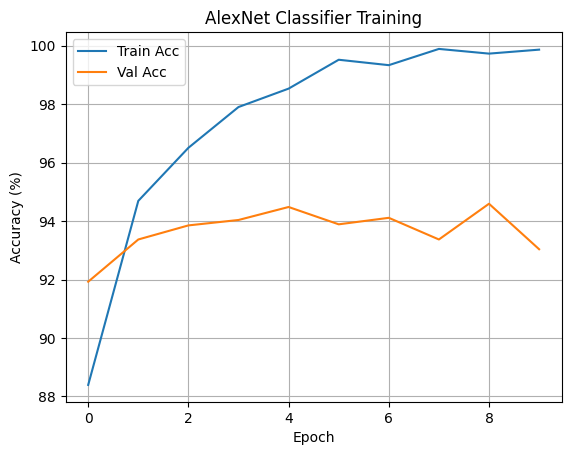

In [19]:
plt.plot(train_acc, label='Train Acc')
plt.plot(val_acc, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('AlexNet Classifier Training')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
torch.save(model.state_dict(), os.path.join("data", "alexnet_classifier_trained.pth"))


In [16]:
model = Alexnet_Classifier().to(device)
model.load_state_dict(torch.load(os.path.join("data", "alexnet_classifier_trained.pth"), map_location=device))
model.eval()

Alexnet_Classifier(
  (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=9, bias=True)
)

In [19]:
# for evaluation on test set
def evaluate_model(model, data_loader, device):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for features, labels in data_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            predictions = outputs.argmax(dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    return accuracy

In [22]:
# Evaluate on test set
test_acc = evaluate_model(model, test_loader, device)
print(f"Trained AlexNet Test Accuracy: {test_acc:.2f}%")

Trained AlexNet Test Accuracy: 94.76%


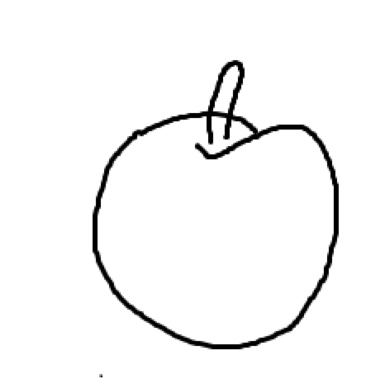

In [28]:
# testing an image prediction with the trained model
image_path = "new/image5.png"

# display image
plt.imshow(image, cmap='gray')  # Use grayscale colormap
plt.axis('off')  # Hide axes
plt.show()

In [ ]:
# Load and preprocess image
image = Image.open(image_path).convert("L")  # Grayscale
image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dim

In [30]:
# extract features from AlexNet
with torch.no_grad():
    features = alexnet.features(image_tensor)
    output = model(features)
    pred_idx = output.argmax(dim=1).item()
    pred_label = CLASSES[pred_idx]

print(f"Predicted Class: {pred_label}")

Predicted Class: apple
